# KISS-ICP running on the EDGAR Munich Dataset

<div class="alert alert-block alert-danger">
<b>Note:</b> Currently tested with Datset version 2
</div>


## Expected dataset layout

```sh
munich_dataset_v2
  ├── metadata.yaml
  |── rosbag.db3
```

In [1]:
# Install KISS-ICP and Plotting tools
# %pip install ipympl evo >/dev/null
# %pip install pyntcloud

import numpy as np
import math

from evo.core.trajectory import PosePath3D
from scipy.spatial.transform import Rotation as R

from evo.core.trajectory import PosePath3D, PoseTrajectory3D

from tum_tools import *
from tum_definitions import *

%load_ext autoreload
%autoreload 2

%matplotlib inline
%matplotlib widget


In [2]:
# data_root = os.getenv("DATASETS")
data_root = "/home/julian/projects/thesis/datasets/ext"

mdv3_full_no_merge = os.path.join(data_root, "converted", "mdv3_full_no_merge")
mdv3_full_merge = os.path.join(data_root, "converted", "mdv3_full_merge")

mdv3_innovusion_no_merge = os.path.join(data_root, "converted", "mdv3_innovusion_no_merge")
mdv3_ouster_no_merge = os.path.join(data_root, "converted", "mdv3_ouster_no_merge")

mdv3_innovusion_merge = os.path.join(data_root, "converted", "mdv3_innovusion_merge")
mdv3_ouster_merge = os.path.join(data_root, "converted", "mdv3_ouster_merge")

mdv3_ouster_inno_front_no_merge = os.path.join(data_root, "converted", "mdv3_ouster_inno_front_no_merge")
mdv3_ouster_inno_front_merge = os.path.join(data_root, "converted", "mdv3_ouster_inno_front_merge")

mdv3_sync_merge = os.path.join(data_root, "converted", "mdv3_sync_merge")


# Note: 'full_no_merge' is not working correctly, for now we skip this dataset
kiss_trajectories = {
    # "mdv3_ouster_inno_front_no_merge": (mdv3_ouster_inno_front_no_merge, None),
    # "mdv3_ouster_inno_front_merge": (mdv3_ouster_inno_front_no_merge, None),
    # "mdv3_full_no_merge": (mdv3_full_no_merge, None),
    "mdv3_full_merge": (mdv3_full_merge, None),
    # "mdv3_innovusion_no_merge": (mdv3_innovusion_no_merge, None),
    # "mdv3_ouster_no_merge": (mdv3_ouster_no_merge, None),
    # "mdv3_innovusion_merge": (mdv3_innovusion_merge, None),
    # "mdv3_ouster_merge": (mdv3_ouster_merge, None)
    # "mdv3_sync_merge": (mdv3_sync_merge, None)
}


In [3]:
config = {
    'config': None,
    'deskew': False,
    'max_range': None,
    'visualize': False,
    'n_scans': -1,
    'jump': 0
}

In [17]:
## READ
import pickle 

name="kiss_trajectories_corrected"

with open(f'data/full2/{name}.pkl', 'rb') as f:
    kiss_trajectories_corrected = pickle.load(f)


In [16]:
## READ

import pickle 

name="kiss_trajectories"

with open(f'data/full2/{name}.pkl', 'rb') as f:
    kiss_trajectories = pickle.load(f)

In [20]:
## WRITE

import pickle 

name="kiss_trajectories_corrected_corr"

with open(f'data/full2/{name}.pkl', 'wb') as f:
    pickle.dump(kiss_trajectories_corrected, f)


In [19]:
## WRITE

import pickle 

name="kiss_trajectories_corr"

with open(f'data/full2/{name}.pkl', 'wb') as f:
    pickle.dump(kiss_trajectories, f)


In [15]:
key = "mdv3_full_merge"

tmp_uncorrected = kiss_trajectories[key]
tmp_corrected = kiss_trajectories_corrected[key]
# kiss_trajectories[key] = tmp_uncorrected

In [18]:
# UPDATE
key = "mdv3_full_merge"

# tmp_uncorrected = kiss_trajectories[key]
# tmp_corrected = kiss_trajectories_corrected[key]

kiss_trajectories[key] = tmp_uncorrected
kiss_trajectories_corrected[key] = tmp_corrected

In [16]:
len(tmp_corrected[2].timestamps)

2967

In [28]:
len(tmp_uncorrected[2].timestamps)

503

In [4]:
# READ GT POSES

# gt_poses_abs, gt_poses_stamps = load_gt_poses(kiss_trajectories[list(kiss_trajectories.keys())[0]][0], wgsToENU)
gt_poses_abs, gt_poses_stamps = load_gt_poses("/home/julian/projects/thesis/datasets/gps_data/mdv3_1", wgsToENU)

gt_poses_t = []
for i in range(len(gt_poses_abs)):
    translation = gt_poses_abs[i]
    
    # Convert quaternion to rotation matrix
    rotation_matrix = np.eye(3)
    
    # Create SE3 transformation matrix
    se3_matrix = np.eye(4)
    se3_matrix[:3, :3] = rotation_matrix
    se3_matrix[:3, 3] = translation
    
    gt_poses_t.append(se3_matrix)
    
gt_poses_stamps = gt_poses_stamps[:len(gt_poses_t)]
gt_poses_se3 = PoseTrajectory3D(poses_se3=gt_poses_t, timestamps=gt_poses_stamps)

In [ ]:
import pickle 

name="gt_poses"

gt_data = {
    "abs_poses": gt_poses_abs,
    "translational": gt_poses_t,
    "trajectory": gt_poses_se3,
    "stamps": gt_poses_stamps
}

with open(f'data/{name}.pkl', 'wb') as f:
    pickle.dump(gt_data, f)

In [11]:
import pickle

name="gt_poses"


with open(f'data/full2/{name}.pkl', 'rb') as f:
    gt_data = pickle.load(f)


In [5]:
# Load the first IMU file to get the initial Heading

# imu_file = os.path.join(mdv3_full_no_merge, 'imu', 'data', '0000000000.txt')
# imu = np.genfromtxt(str(imu_file), delimiter=" ", dtype=np.float64)
# gt_orientation_xyzw = imu[3:7] # Quaternion xyzw
# gt_orientation_wxyz = [gt_orientation_xyzw[3], gt_orientation_xyzw[0], gt_orientation_xyzw[1], gt_orientation_xyzw[2]]

# euler_angles = R.from_quat(gt_orientation_xyzw).as_euler('xyz')

# Extract yaw angle (heading) in radians
# yaw = - 0.5*(math.pi/2  - euler_angles[2])
yaw = math.pi/2  - (101*math.pi/180)
yaw2 = math.pi/2  - (205*math.pi/180)

gt_roation_matrix = R.from_euler('xyz', [0,0,yaw]).as_matrix()
gt_roation_matrix2 = R.from_euler('xyz', [0,0,yaw2]).as_matrix()

In [ ]:
# DEBUGGING: Getting the euler angles for all permutations of the sequences

from itertools import permutations
a = ['x', 'y', 'z']
perms = set(permutations(a))

for p in perms:
    euler_angles = R.from_quat(gt_orientation_xyzw).as_euler(f'{p[0]}{p[1]}{p[2]}', degrees=True)
    print(f"Sequence: {p[0]}{p[1]}{p[2]}\t {euler_angles}")


In [6]:
def get_kiss_poses(dataset: dict, gt_poses=None):
    for name, value in dataset.items():
        print(f"Proccesing {name}")
        path = value[0]
        kiss_poses, trajectory_poses, timestamps = run_kiss_icp_pipeline(path, config, gt_poses)
        dataset[name] = (path, kiss_poses, trajectory_poses, timestamps)


In [7]:
# # Run full KISS-ICP Pipeline
get_kiss_poses(kiss_trajectories)

# # Run single KISS-ICP Pipeline
# instance = "mdv3_innovusion_no_merge"
# ds = {instance: kiss_trajectories[instance]}
# get_kiss_poses(ds)


Proccesing mdv3_full_merge
Trying to guess how to read your data: `pip install "kiss-icp[all]"` is required


  0%|          | 0/2893 [00:00<?, ? frames/s]

[WARNING] No GT poses available, skipping evaluation


In [8]:
from copy import deepcopy
kiss_trajectories_corrected = deepcopy(kiss_trajectories)

In [9]:
# Apply initial heading corrections and put in new dictionary

origin_se3 = np.eye(4)
origin_se3[:3,:3] = gt_roation_matrix

ref_traj = PosePath3D(poses_se3=[origin_se3])

for ds in kiss_trajectories_corrected.keys():
    kiss_trajectories_corrected[ds][2].align_origin(ref_traj)

In [29]:
from copy import deepcopy

origin_se3 = np.eye(4)
origin_se3_2 = np.eye(4)
origin_se3[:3,:3] = gt_roation_matrix
origin_se3_2[:3,:3] = gt_roation_matrix2

ref_traj = PosePath3D(poses_se3=[origin_se3])
ref_traj2 = PosePath3D(poses_se3=[origin_se3_2])

kiss_trajectories["mdv3"] = deepcopy(kiss_trajectories["mdv3_sync_merge"])
kiss_trajectories["mdv3_101"] = deepcopy(kiss_trajectories["mdv3_sync_merge"])
kiss_trajectories["mdv3_205"] = deepcopy(kiss_trajectories["mdv3_sync_merge"])
kiss_trajectories["mdv3_101"][2].align_origin(ref_traj)
kiss_trajectories["mdv3_205"][2].align_origin(ref_traj2)

array([[-0.42261826,  0.90630779,  0.        ,  0.        ],
       [-0.90630779, -0.42261826,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [30]:
data = {
    "KISS-Poses Uncorrected": kiss_trajectories["mdv3"],
    "KISS-Poses Heading 101°": kiss_trajectories["mdv3_101"],
    "KISS-Poses Heading 205°": kiss_trajectories["mdv3_205"],
    
        }

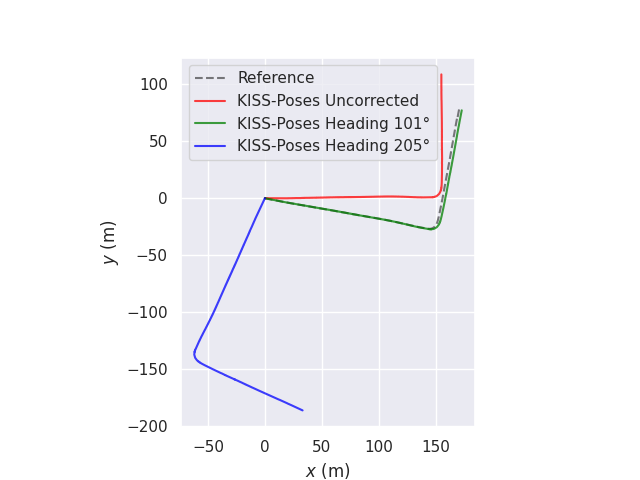

In [32]:

fig = plot_trajectories(data, gt_data["abs_poses"])
plt.savefig("figures/heading-kiss-poses.pdf", format="pdf", bbox_inches="tight")


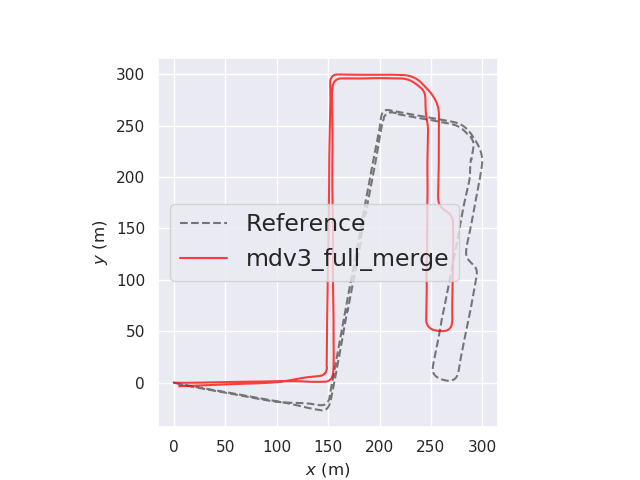

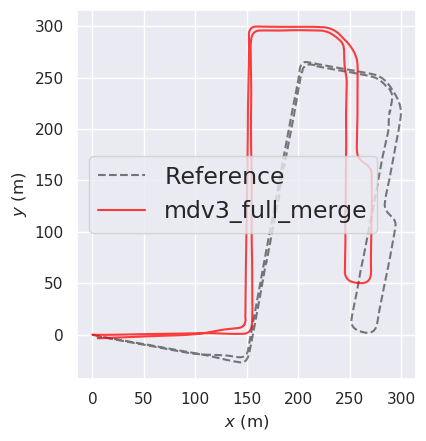

In [14]:
plot_trajectories(kiss_trajectories, gt_data["abs_poses"])
# 

In [ ]:
kiss_trajectories_corrected["reference"] = (None, None, PosePath3D(poses_se3=gt_poses_t))
tmp_dict = {
            "example":kiss_trajectories_corrected["mdv3_ouster_merge"],
            "reference" : kiss_trajectories_corrected["reference"]
            }
plot_trajectories(tmp_dict, gt_poses_abs)
del kiss_trajectories_corrected["reference"]

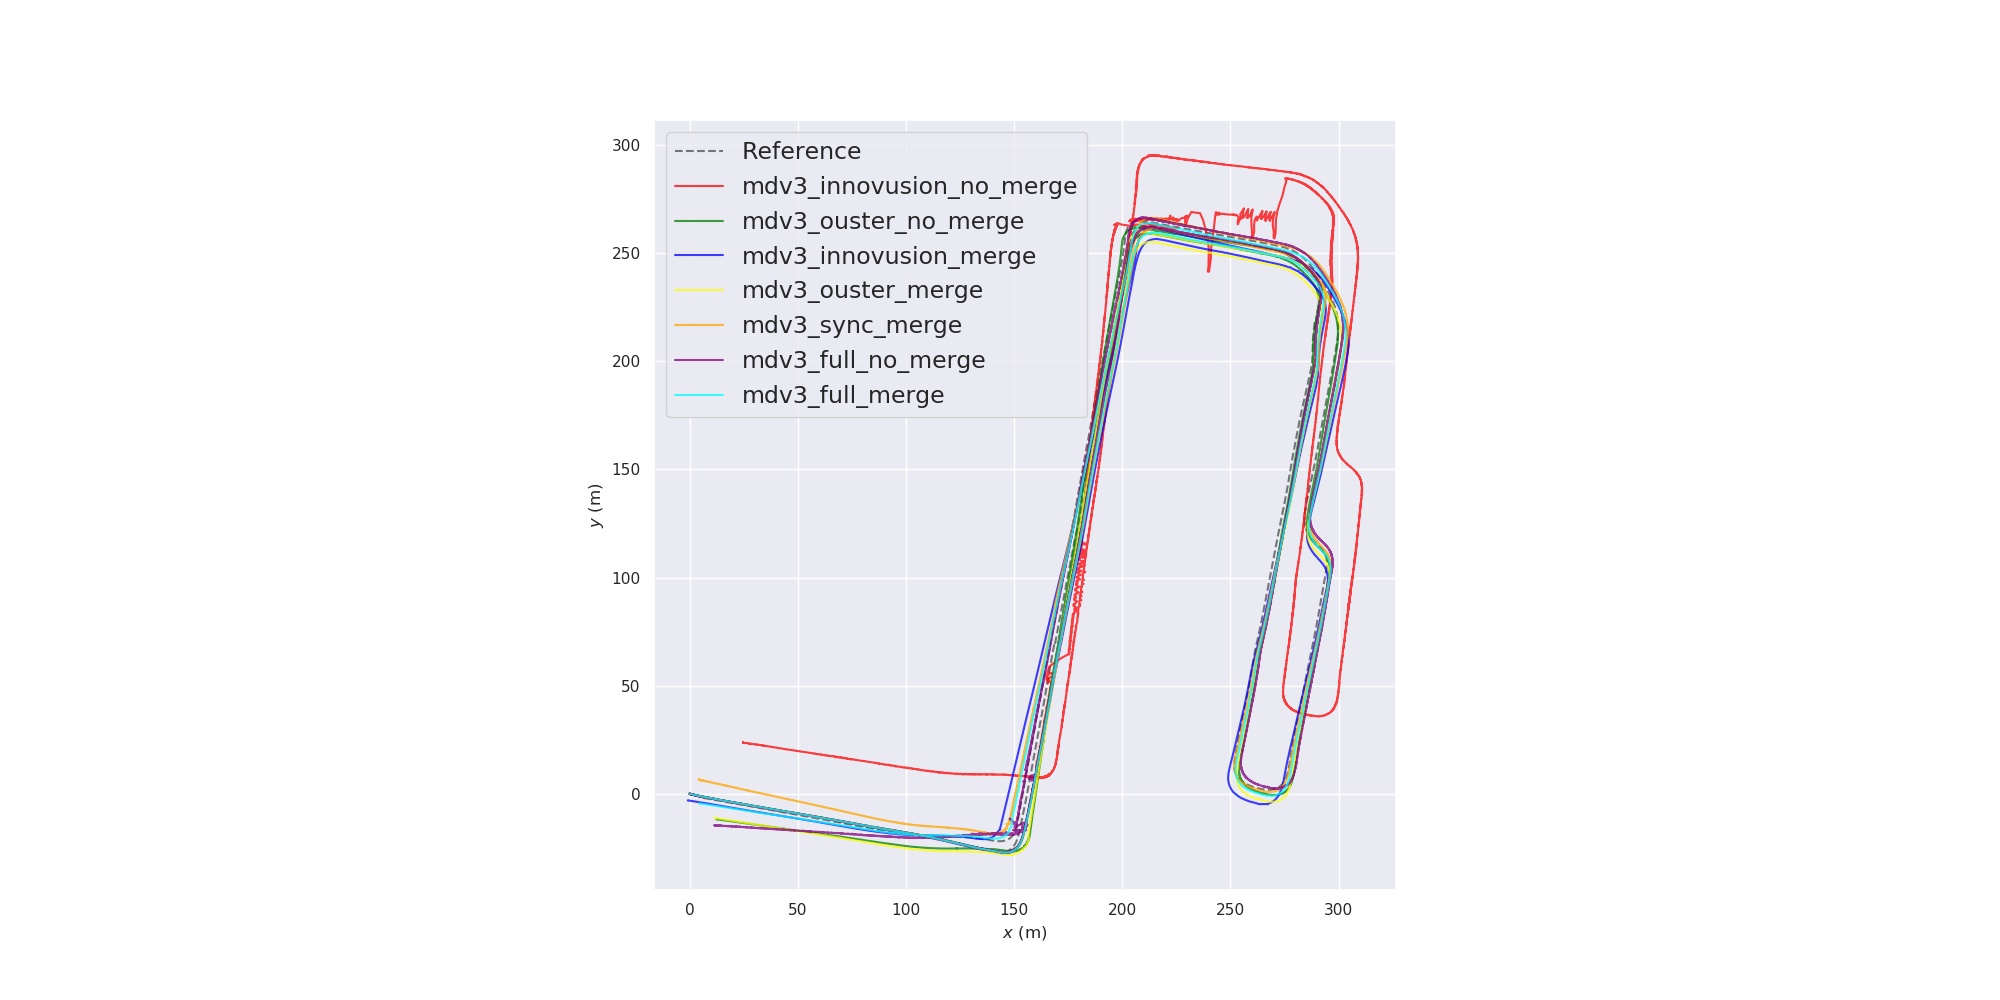

In [21]:
plot_trajectories(kiss_trajectories_corrected, gt_data["abs_poses"], figsize=(20,10))
plt.savefig("figures/full-compare.pdf", format="pdf", bbox_inches="tight")
